In [103]:
RESULTS_PATH = "../results/recidivism_false_only"
# MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "Qwen/Qwen-1_8B", "Qwen/Qwen-7B", "Qwen/Qwen-14B"]
MODELS_TO_PLOT = ["openai-gpt","gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl","Qwen/Qwen-7B","meta-llama/Llama-2-7b-chat-hf"]
PLOT_NAME="accuracy" # "agreement_rate" or "accuracy"

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from IPython.display import display
from collections import defaultdict
import os
import glob
import json
import pickle

In [105]:
records = []
for result_filename in glob.glob(os.path.join(RESULTS_PATH, "**/results_summary.json"), recursive=True):
    result=pickle.load(open(result_filename.replace("results_summary.json", "results.pkl"), "rb"))
    config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
    config = json.load(open(config_file, "r"))
    if config["model_size"] not in MODELS_TO_PLOT:
        continue
    if 'seed' not in config:
        config['seed'] = 0
    record = config.copy()
    if 'weak_model' in config:
        for k in record['weak_model']:
            if k == 'model_size':
                assert record['weak_model'][k] == record['weak_model_size']
            record['weak_' + k] = record['weak_model'][k]
        del record['weak_model']
    record['results'] = result
    record.update(json.load(open(result_filename)))
    records.append(record)

In [106]:
records[0]['results']['test_results'][0]['acc']

True

In [107]:
results=[]
for record in records:
    if 'weak_model_size' not in record:
        record['weak_model_size'] = "ground_truth"
    results.append({"model_size": record['model_size'], 
                    "supervision": record['weak_model_size'], 
                    "ds_name": record['ds_name'], 
                    "seed": record['seed'], 
                    "accuracy": record['accuracy'],
                    'test_results': record['results']['test_results'],
                    'inference_results': record['results']['inference_results']})
    
supervision_results=defaultdict(dict)
for r in results:
    if r['supervision'] == "ground_truth":
        supervision_results[r["ds_name"]][r["model_size"]]=r['test_results']

for r in results:
    if r['supervision'] == "ground_truth":
        supervision_result=[True]*len(r['test_results'])
    else:
        supervision_result=supervision_results[r["ds_name"]][r["supervision"]]
        supervision_result=[x['acc'] for x in supervision_result]
    r_tr=[x['acc'] for x in r['test_results']]
    r['agreement_rate'] = np.mean([r_tr[i]==supervision_result[i] for i in range(len(r_tr))])
    


In [108]:
# sort values according to the index in the list

df = pd.DataFrame.from_records(results).sort_values(['ds_name', 'model_size'])

/tmp/ipykernel_2836276/2424535734.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x.get_text().split("/")[-1] for x in ax.get_xticklabels()],rotation=45)


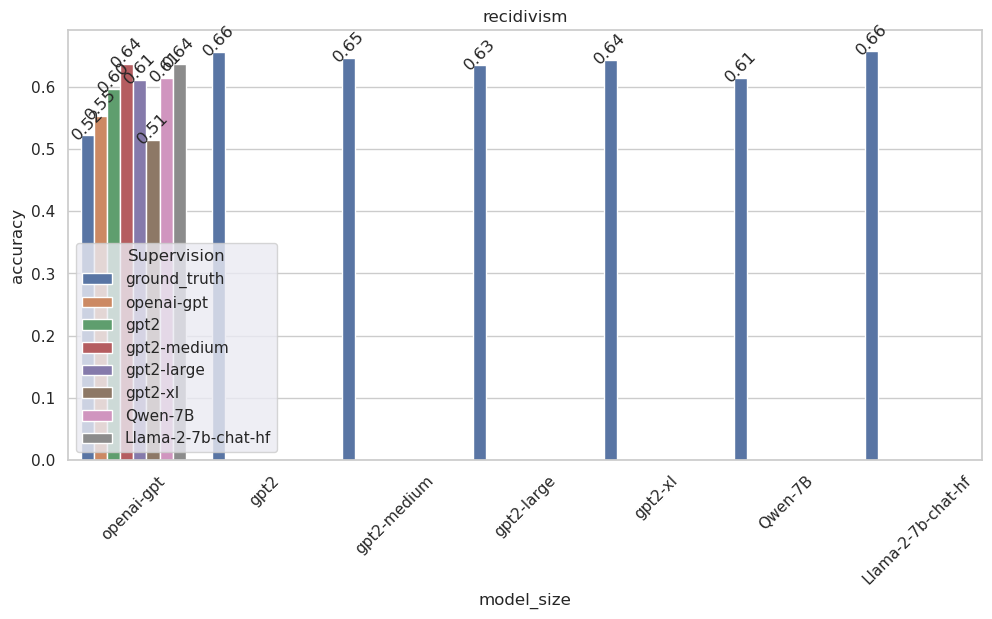

In [109]:
# draw bar plot for each dataset
for ds_name in df.ds_name.unique():
    df_ds = df[df.ds_name == ds_name]
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set(font_scale=1)
    # # use tight layout
    plt.tight_layout()
    # if a the label is in hue_order but not in hue, it will not be displayed
    hue_order = [i for i in ["ground_truth"] + MODELS_TO_PLOT if i in df_ds.supervision.unique()]
    order = [i for i in MODELS_TO_PLOT if i in df_ds.model_size.unique()]
    bp=sns.barplot(data=df_ds, 
                x='model_size', 
                y=PLOT_NAME, 
                hue='supervision',
                hue_order=hue_order,
                order=order,
                ax=ax,)
    
   
    # do modification of hue labels (split by / and remove first part)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=[x.split("/")[-1] for x in labels], title="Supervision")
    sns.move_legend(ax, "lower left")

    # do modification of x labels (split by / and remove first part)
    ax.set_xticklabels([x.get_text().split("/")[-1] for x in ax.get_xticklabels()],rotation=45)
    

    for p in ax.patches:
        if p.get_height() == 0:
            continue
        ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2, 
                    p.get_height()), 
                    ha='center', 
                    va='center',
                   size=12, 
                   xytext=(0, 8),
                   textcoords='offset points',
                   rotation=45)
    ax.set_title(ds_name)
    plt.savefig(f"{RESULTS_PATH}/{ds_name}_{PLOT_NAME}.png",bbox_inches='tight')
    plt.show()